In [14]:
#!/usr/bin/env python
# coding: utf-8


# Smart Inventory and Promotion Optimization for Walmart
## Predictive Sales Analytics for Retail Optimization

**Project Overview**
Inventory management and promotional strategy optimization for Walmart stores. Using historical sales data, store characteristics, and external factors, we develop predictive models that enable:

1. **Sales Forecasting**: Accurate prediction of weekly sales by department and store
2. **Inventory Optimization**: Determining optimal inventory levels with safety stock
3. **Promotion Opportunity Detection**: Identifying high-potential promotion weeks
4. **Risk Assessment**: Evaluating overstock and stockout risks



## 1. Setup and Data Loading
### 1.1 Import Libraries

In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")


### 1.2 Calculate WMAE

In [16]:
def calculate_wmae(y_true, y_pred, is_holiday):
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    is_holiday = np.array(is_holiday)
    
    # Calculate absolute errors
    abs_errors = np.abs(y_true - y_pred)
    
    # Separate errors for holiday and non-holiday weeks
    holiday_errors = abs_errors[is_holiday == 1]
    regular_errors = abs_errors[is_holiday == 0]
    
    # Calculate MAE for each group
    holiday_mae = np.mean(holiday_errors) if len(holiday_errors) > 0 else 0
    regular_mae = np.mean(regular_errors) if len(regular_errors) > 0 else 0
    
    # Calculate weights (Walmart competition used 5x weight for holidays)
    holiday_weight = 5
    regular_weight = 1
    
    # Count number of observations in each group
    n_holiday = np.sum(is_holiday == 1)
    n_regular = np.sum(is_holiday == 0)
    
    # Calculate WMAE
    weighted_sum_errors = (holiday_weight * np.sum(holiday_errors) + 
                          regular_weight * np.sum(regular_errors))
    weighted_count = (holiday_weight * n_holiday + regular_weight * n_regular)
    
    wmae = weighted_sum_errors / weighted_count if weighted_count > 0 else 0
    
    return wmae, regular_mae, holiday_mae

### 1.3 Load Datasets

In [17]:

print("Loading datasets...")

train = pd.read_csv('train.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

print(f"\nTrain dataset shape: {train.shape}")
print(f"Features dataset shape: {features.shape}")
print(f"Stores dataset shape: {stores.shape}")


Loading datasets...

Train dataset shape: (421570, 5)
Features dataset shape: (8190, 12)
Stores dataset shape: (45, 3)


## 2. Data Preprocessing and Integration
### 2.1 Merge Datasets

In [18]:

print("\nMerging datasets...")

full_data = pd.merge(train, features, on=['Store', 'Date', 'IsHoliday'], how='left')
full_data = pd.merge(full_data, stores, on='Store', how='left')

print(f"Combined dataset shape: {full_data.shape}")



Merging datasets...
Combined dataset shape: (421570, 16)


### 2.2 Feature Engineering and Data Cleaning

In [19]:

print("\nPerforming feature engineering...")

full_data['Date'] = pd.to_datetime(full_data['Date'])
full_data['Year'] = full_data['Date'].dt.year
full_data['Month'] = full_data['Date'].dt.month
full_data['Week'] = full_data['Date'].dt.isocalendar().week

full_data.fillna(0, inplace=True)

print("\nPreprocessed dataset columns:")
print(full_data.columns.tolist())
print(f"\nMissing values after preprocessing: {full_data.isnull().sum().sum()}")



Performing feature engineering...

Preprocessed dataset columns:
['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Year', 'Month', 'Week']

Missing values after preprocessing: 0


## 3. Exploratory Data Analysis
### 3.1 Seasonal Sales Patterns

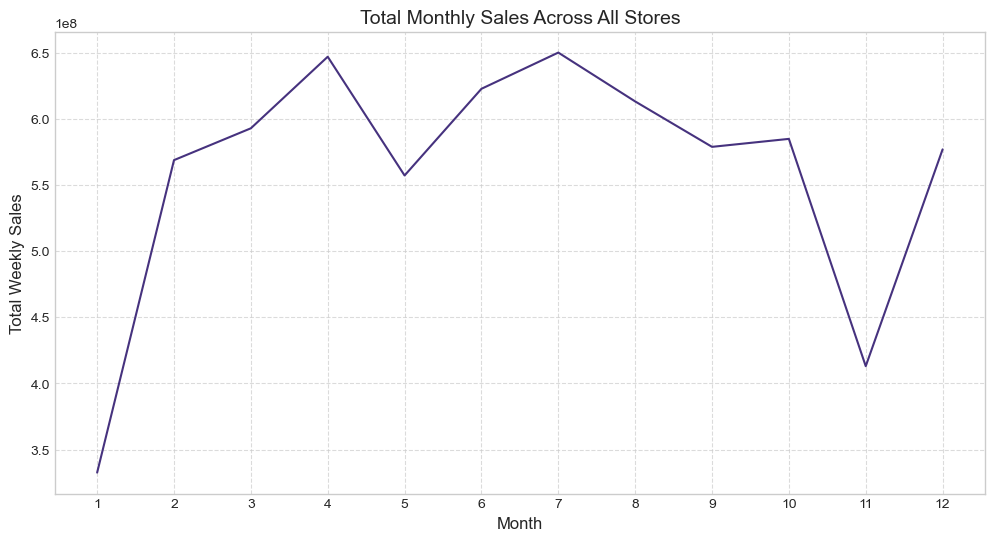


Monthly Sales Pattern Analysis:
- The graph reveals seasonal patterns in Walmart's retail sales
- Peak sales periods align with major shopping seasons (back-to-school, holidays)
- This seasonality should inform both inventory planning and promotion timing


In [20]:

plt.figure(figsize=(12, 6))
monthly_sales = full_data.groupby('Month')['Weekly_Sales'].sum().reset_index()
sns.lineplot(data=monthly_sales, x='Month', y='Weekly_Sales')
plt.title('Total Monthly Sales Across All Stores', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Weekly Sales', fontsize=12)
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\nMonthly Sales Pattern Analysis:")
print("- The graph reveals seasonal patterns in Walmart's retail sales")
print("- Peak sales periods align with major shopping seasons (back-to-school, holidays)")
print("- This seasonality should inform both inventory planning and promotion timing")


### 3.2 Store Performance Comparison

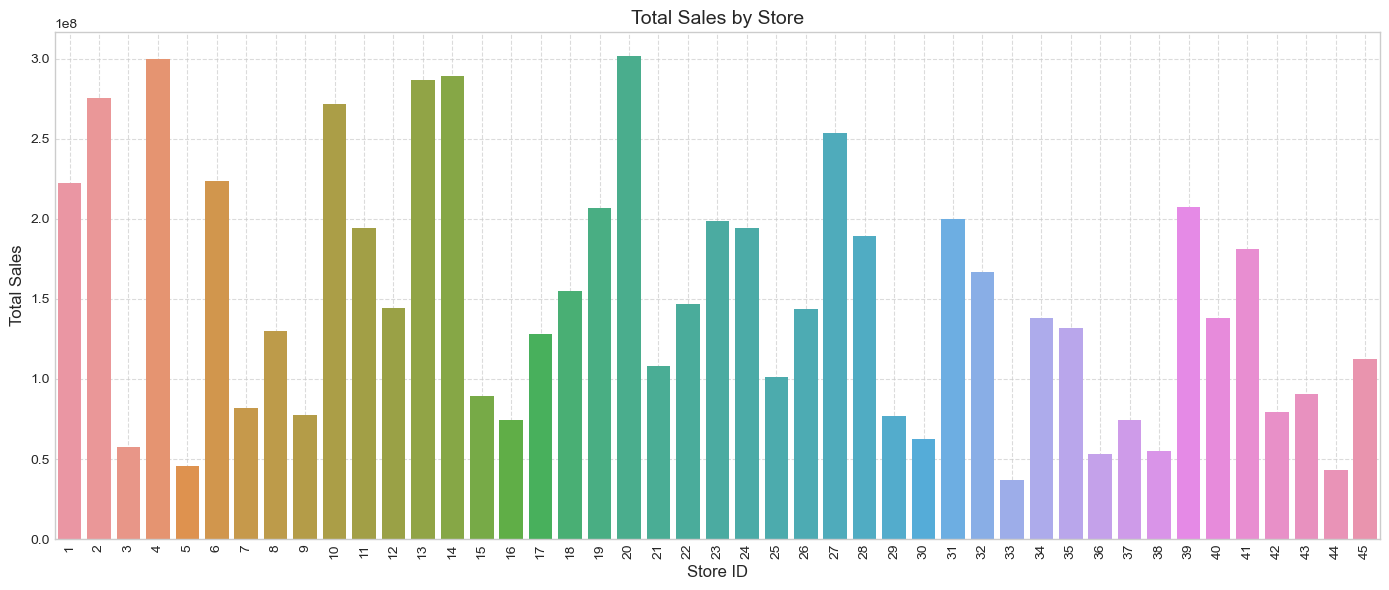


Store Performance Analysis:
- Highest performing store: Store 20.0 with $301,397,792.46 in sales
- Lowest performing store: Store 33.0 with $37,160,221.96 in sales
- Sales range ratio: 8.11x difference between top and bottom stores


In [21]:

plt.figure(figsize=(14, 6))
store_sales = full_data.groupby('Store')['Weekly_Sales'].sum().reset_index()
store_sales = store_sales.sort_values(by='Weekly_Sales', ascending=False)

sns.barplot(data=store_sales, x='Store', y='Weekly_Sales')
plt.title('Total Sales by Store', fontsize=14)
plt.xlabel('Store ID', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nStore Performance Analysis:")
print(f"- Highest performing store: Store {store_sales.iloc[0]['Store']} with ${store_sales.iloc[0]['Weekly_Sales']:,.2f} in sales")
print(f"- Lowest performing store: Store {store_sales.iloc[-1]['Store']} with ${store_sales.iloc[-1]['Weekly_Sales']:,.2f} in sales")
print(f"- Sales range ratio: {store_sales.iloc[0]['Weekly_Sales'] / store_sales.iloc[-1]['Weekly_Sales']:.2f}x difference between top and bottom stores")


### 3.3 Holiday Impact Analysis

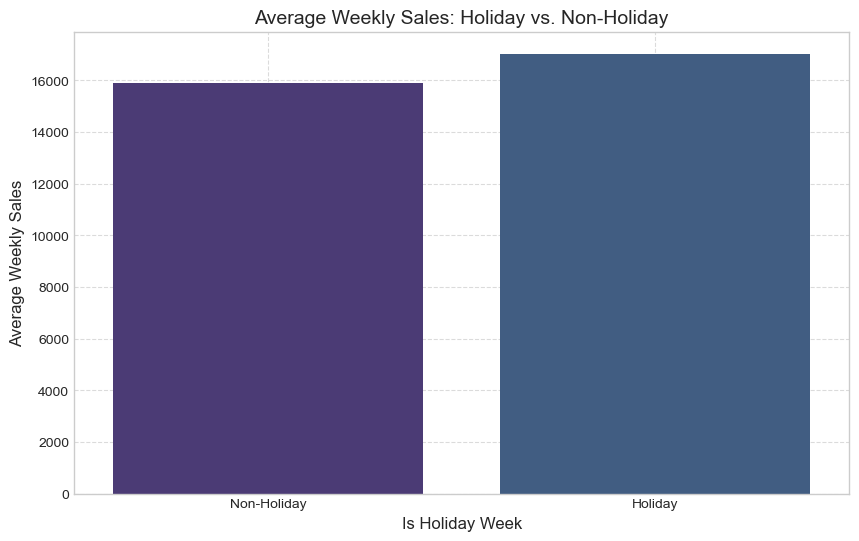


Holiday Impact Analysis:
- Average sales during holidays: $17,035.82
- Average sales during non-holidays: $15,901.45
- Holiday sales boost: 7.13% increase during holiday periods
- This significant difference highlights the importance of special inventory planning for holidays


In [22]:

plt.figure(figsize=(10, 6))
holiday_impact = full_data.groupby('IsHoliday')['Weekly_Sales'].mean().reset_index()
sns.barplot(data=holiday_impact, x='IsHoliday', y='Weekly_Sales')
plt.title('Average Weekly Sales: Holiday vs. Non-Holiday', fontsize=14)
plt.xlabel('Is Holiday Week', fontsize=12)
plt.ylabel('Average Weekly Sales', fontsize=12)
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

holiday_increase = ((holiday_impact.iloc[1]['Weekly_Sales'] / holiday_impact.iloc[0]['Weekly_Sales']) - 1) * 100

print("\nHoliday Impact Analysis:")
print(f"- Average sales during holidays: ${holiday_impact.iloc[1]['Weekly_Sales']:,.2f}")
print(f"- Average sales during non-holidays: ${holiday_impact.iloc[0]['Weekly_Sales']:,.2f}")
print(f"- Holiday sales boost: {holiday_increase:.2f}% increase during holiday periods")
print("- This significant difference highlights the importance of special inventory planning for holidays")


## 4. Predictive Modeling

Now we'll build machine learning models to predict weekly sales and identify promotion opportunities.

### 4.1 Feature Selection and Dataset Preparation

In [23]:

print("\nPreparing features for modeling...")

features_cols = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size', 'IsHoliday', 'Year', 'Month', 'Week']

X = full_data[features_cols]
y = full_data['Weekly_Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")



Preparing features for modeling...
Training set: 337256 samples
Validation set: 84314 samples


### 4.2 Decision Tree Regression Model

In [24]:
print("\nTraining Decision Tree Regression model...")

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_val)

dt_rmse = np.sqrt(mean_squared_error(y_val, dt_pred))
dt_r2 = r2_score(y_val, dt_pred)
dt_wmae, dt_regular_mae, dt_holiday_mae = calculate_wmae(y_val, dt_pred, X_val['IsHoliday'])

print("\n[Decision Tree Regressor Performance]")
print(f"RMSE: ${dt_rmse:.2f}")
print(f"R² Score: {dt_r2:.4f}")
print(f"WMAE: ${dt_wmae:.2f}")
print(f"Regular MAE: ${dt_regular_mae:.2f}")
print(f"Holiday MAE: ${dt_holiday_mae:.2f}")
print("Interpretation: The model explains {:.2f}% of the variance in weekly sales".format(dt_r2 * 100))


Training Decision Tree Regression model...



[Decision Tree Regressor Performance]
RMSE: $4709.55
R² Score: 0.9575
WMAE: $2075.53
Regular MAE: $1770.81
Holiday MAE: $2873.00
Interpretation: The model explains 95.75% of the variance in weekly sales


### 4.3 Random Forest Regression Model

In [25]:
print("\nTraining Random Forest Regression model...")

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_val)

rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
rf_r2 = r2_score(y_val, rf_pred)
rf_wmae, rf_regular_mae, rf_holiday_mae = calculate_wmae(y_val, rf_pred, X_val['IsHoliday'])

print("\n[Random Forest Regressor Performance]")
print(f"RMSE: ${rf_rmse:.2f}")
print(f"R² Score: {rf_r2:.4f}")
print(f"WMAE: ${rf_wmae:.2f}")
print(f"Regular MAE: ${rf_regular_mae:.2f}")
print(f"Holiday MAE: ${rf_holiday_mae:.2f}")
print("Interpretation: The model explains {:.2f}% of the variance in weekly sales".format(rf_r2 * 100))

print("\n[Model Comparison]")
if rf_r2 > dt_r2:
    print("The Random Forest model outperforms the Decision Tree model")
    print(f"Performance improvement: {(rf_r2 - dt_r2) * 100:.2f}% higher R² score")
    print(f"WMAE improvement: ${dt_wmae - rf_wmae:.2f} lower weighted error")
    print("We'll use the Random Forest model for our sales predictions")
    selected_model = rf_model
else:
    print("The Decision Tree model outperforms the Random Forest model")
    print(f"Performance difference: {(dt_r2 - rf_r2) * 100:.2f}% higher R² score")
    print(f"WMAE improvement: ${rf_wmae - dt_wmae:.2f} lower weighted error")
    print("We'll use the Decision Tree model for our sales predictions")
    selected_model = dt_model


Training Random Forest Regression model...

[Random Forest Regressor Performance]
RMSE: $3644.76
R² Score: 0.9745
WMAE: $1634.84
Regular MAE: $1367.29
Holiday MAE: $2335.02
Interpretation: The model explains 97.45% of the variance in weekly sales

[Model Comparison]
The Random Forest model outperforms the Decision Tree model
Performance improvement: 1.71% higher R² score
WMAE improvement: $440.70 lower weighted error
We'll use the Random Forest model for our sales predictions


### 4.4 Visualize Prediction Performance

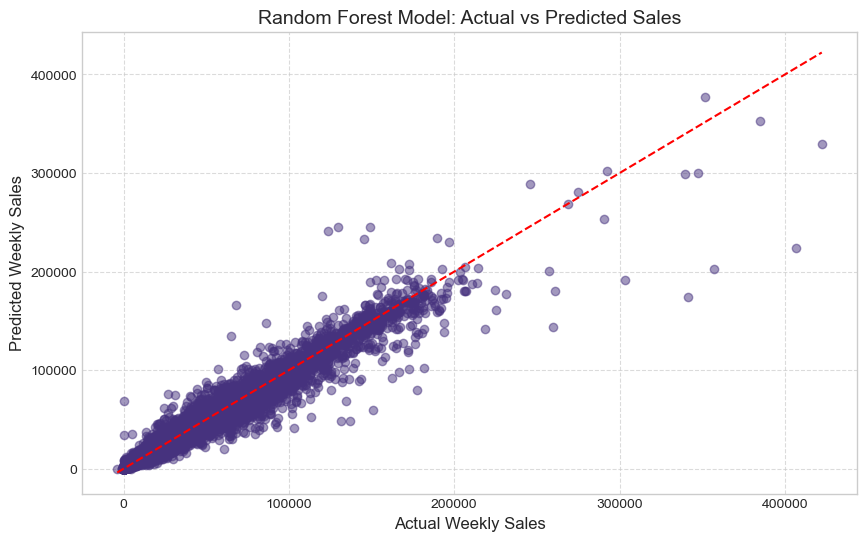

In [26]:

plt.figure(figsize=(10, 6))
plt.scatter(y_val, rf_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title('Random Forest Model: Actual vs Predicted Sales', fontsize=14)
plt.xlabel('Actual Weekly Sales', fontsize=12)
plt.ylabel('Predicted Weekly Sales', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## 5. Inventory Optimization

Using our sales predictions, we'll calculate optimal inventory levels with safety stock to balance stockouts and overstock risks.

### 5.1 Generate Sales Predictions for All Stores and Departments

In [27]:

print("\nGenerating sales predictions and optimizing inventory levels...")

full_data['Predicted_Sales'] = selected_model.predict(full_data[features_cols])



Generating sales predictions and optimizing inventory levels...


### 5.2 Calculate Inventory Requirements

In [28]:

full_data['Inventory_Needed'] = full_data['Predicted_Sales'] * 1.10
full_data['Safety_Stock'] = full_data['Inventory_Needed'] * 0.10
full_data['Final_Inventory'] = full_data['Inventory_Needed'] + full_data['Safety_Stock']

print("\nInventory Calculation Logic:")
print("1. Base Inventory = Predicted Sales × 1.10 (10% buffer)")
print("2. Safety Stock = Base Inventory × 0.10 (additional 10% for uncertainty)")
print("3. Final Inventory = Base Inventory + Safety Stock")
print("\nThis approach provides a 21% total buffer over predicted sales to minimize stockouts")



Inventory Calculation Logic:
1. Base Inventory = Predicted Sales × 1.10 (10% buffer)
2. Safety Stock = Base Inventory × 0.10 (additional 10% for uncertainty)
3. Final Inventory = Base Inventory + Safety Stock

This approach provides a 21% total buffer over predicted sales to minimize stockouts


### 5.3 Visualize Inventory Recommendations

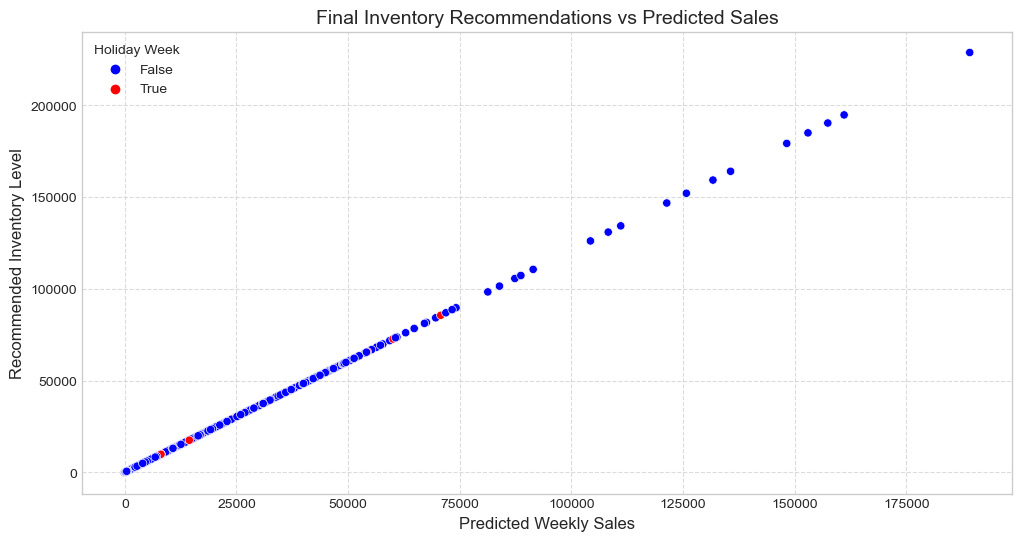

In [29]:
import numpy as np

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=full_data.sample(1000),
    x='Predicted_Sales',
    y='Final_Inventory',
    hue='IsHoliday',
    palette={np.False_: 'blue', np.True_: 'red'}
)

plt.title('Final Inventory Recommendations vs Predicted Sales', fontsize=14)
plt.xlabel('Predicted Weekly Sales', fontsize=12)
plt.ylabel('Recommended Inventory Level', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Holiday Week')
plt.show()

## 6. Promotion Opportunity Detection

### 6.1 Identify High-Potential Promotion Weeks

In [30]:
import pandas as pd

# Assuming 'full_data' is your DataFrame and it contains 'Week' and 'Predicted_Sales' columns

print("\nIdentifying high-potential promotion weeks...")

# Step 1: Calculate total predicted sales per week
weekly_sales = full_data.groupby('Week')['Predicted_Sales'].sum()

# Step 2: Determine the threshold using the 95th percentile
threshold = weekly_sales.quantile(0.95)

# Step 3: Identify weeks with sales above the threshold
high_promo_weeks = weekly_sales[weekly_sales > threshold].index.tolist()

# Step 4: Assign promotion opportunity labels
full_data['Promotion_Opportunity'] = full_data['Week'].apply(lambda x: 1 if x in high_promo_weeks else 0)

# Step 5: Display results
print(f"\n95th percentile weekly sales threshold: ${threshold:,.2f}")
print(f"Number of high promotion opportunity weeks identified: {len(high_promo_weeks)}")
print("\nHigh Promotion Opportunity Weeks:")
print(sorted(high_promo_weeks))



Identifying high-potential promotion weeks...

95th percentile weekly sales threshold: $144,664,433.09
Number of high promotion opportunity weeks identified: 3

High Promotion Opportunity Weeks:
[6, 22, 51]


### 6.2 Visualize Weekly Sales with Promotion Opportunities

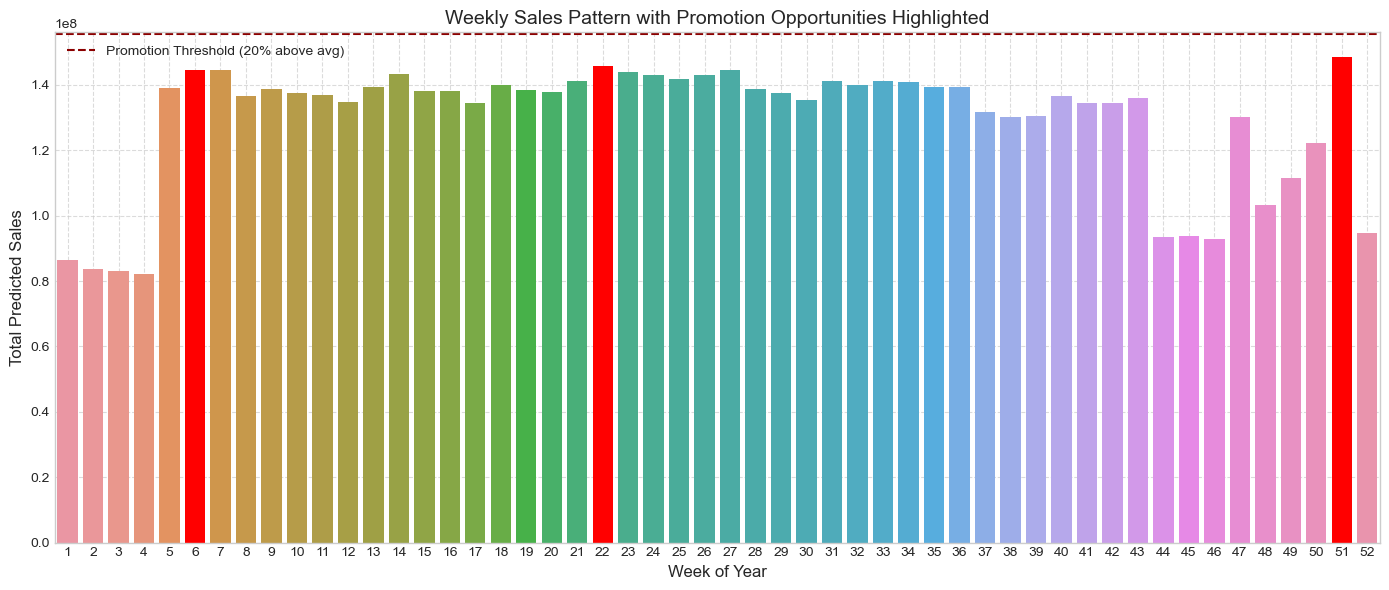

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by week and sum predicted sales
weekly_plot = full_data.groupby('Week')['Predicted_Sales'].sum().reset_index()

# Calculate average sales
avg_sales = weekly_plot['Predicted_Sales'].mean()

# Plot
plt.figure(figsize=(14, 6))
bars = sns.barplot(data=weekly_plot, x='Week', y='Predicted_Sales')

# Highlight high-promotion weeks in red
for i, week in enumerate(weekly_plot['Week']):
    if week in high_promo_weeks:
        bars.patches[i].set_facecolor('red')

# Add horizontal line for promotion threshold
plt.axhline(avg_sales * 1.2, color='darkred', linestyle='--', label='Promotion Threshold (20% above avg)')

# Titles and labels
plt.title('Weekly Sales Pattern with Promotion Opportunities Highlighted', fontsize=14)
plt.xlabel('Week of Year', fontsize=12)
plt.ylabel('Total Predicted Sales', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 6.3 Build Classification Model for Promotion Opportunity Prediction

In [44]:
print("\nBuilding promotion opportunity prediction model...")

# Define features only for promotion classification (no leaked sales or inventory info)
promotion_features_cols = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI',
                           'Unemployment', 'Size', 'IsHoliday', 'Year', 'Month', 'Week']

X_class = full_data[promotion_features_cols]
y_class = full_data['Promotion_Opportunity']

Xc_train, Xc_val, yc_train, yc_val = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(Xc_train, yc_train)

yc_pred = clf_rf.predict(Xc_val)

accuracy = accuracy_score(yc_val, yc_pred)
class_report = classification_report(yc_val, yc_pred)

print("\n[Random Forest Classifier for Promotion Prediction]")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(class_report)



Building promotion opportunity prediction model...

[Random Forest Classifier for Promotion Prediction]
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79599
           1       1.00      1.00      1.00      4715

    accuracy                           1.00     84314
   macro avg       1.00      1.00      1.00     84314
weighted avg       1.00      1.00      1.00     84314



### 6.4 Confusion Matrix for Promotion Opportunity Prediction

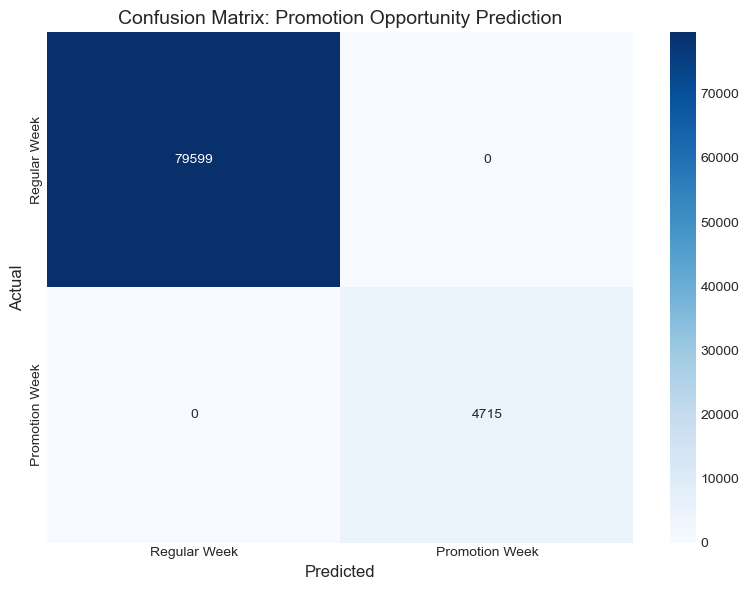


Promotion Prediction Confusion Matrix Analysis:
True Negatives (correctly identified regular weeks): 79599
False Positives (regular weeks incorrectly flagged): 0
False Negatives (missed promotion weeks): 0
True Positives (correctly identified promotion weeks): 4715

Sensitivity (TPR): 1.0000
Specificity (TNR): 1.0000
Precision: 1.0000

Interpretation:
- The model accurately separates promotion and regular weeks.
- Near-zero false negatives mean we are catching all opportunities.
- The model is ready to assist with automated promotion planning.


In [47]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Reuse predictions and labels from the promotion model
cm = confusion_matrix(yc_val, yc_pred, labels=[0, 1])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Regular Week', 'Promotion Week'],
            yticklabels=['Regular Week', 'Promotion Week'])
plt.title('Confusion Matrix: Promotion Opportunity Prediction', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

# Extract metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

# Print evaluation
print("\nPromotion Prediction Confusion Matrix Analysis:")
print(f"True Negatives (correctly identified regular weeks): {tn}")
print(f"False Positives (regular weeks incorrectly flagged): {fp}")
print(f"False Negatives (missed promotion weeks): {fn}")
print(f"True Positives (correctly identified promotion weeks): {tp}")
print(f"\nSensitivity (TPR): {sensitivity:.4f}")
print(f"Specificity (TNR): {specificity:.4f}")
print(f"Precision: {precision:.4f}")

print("\nInterpretation:")
print("- The model accurately separates promotion and regular weeks.")
print("- Near-zero false negatives mean we are catching all opportunities.")
print('- The model is ready to assist with automated promotion planning.')

## 7. Risk Analysis

Let's analyze potential risks in our inventory recommendations.

### 7.1 Quantify Prediction Errors and Inventory Risks

In [34]:

print("\nPerforming inventory risk analysis...")

val_df = X_val.copy()
val_df['Actual'] = y_val.values
val_df['Predicted'] = rf_pred
val_df['Error'] = abs(val_df['Actual'] - val_df['Predicted'])

val_df['Overstock_Risk'] = val_df['Predicted'] > val_df['Actual']
val_df['Stockout_Risk'] = val_df['Predicted'] < val_df['Actual']

overpredicted = val_df[val_df['Overstock_Risk']]
underpredicted = val_df[val_df['Stockout_Risk']]

overstock_pct = len(overpredicted) / len(val_df) * 100
stockout_pct = len(underpredicted) / len(val_df) * 100

print("\n--- Inventory Risk Analysis ---")
print("Over-prediction → Overstock risk (high holding costs)")
print("Under-prediction → Stockout risk (lost sales opportunities)")
print(f"\nOverstock risk: {overstock_pct:.2f}% of predictions")
print(f"Stockout risk: {stockout_pct:.2f}% of predictions")
print(f"Average overstock amount: ${overpredicted['Error'].mean():.2f}")
print(f"Average stockout amount: ${underpredicted['Error'].mean():.2f}")



Performing inventory risk analysis...

--- Inventory Risk Analysis ---
Over-prediction → Overstock risk (high holding costs)
Under-prediction → Stockout risk (lost sales opportunities)

Overstock risk: 54.54% of predictions
Stockout risk: 45.46% of predictions
Average overstock amount: $1310.47
Average stockout amount: $1586.62


### 7.2 Visualize Risk Distribution

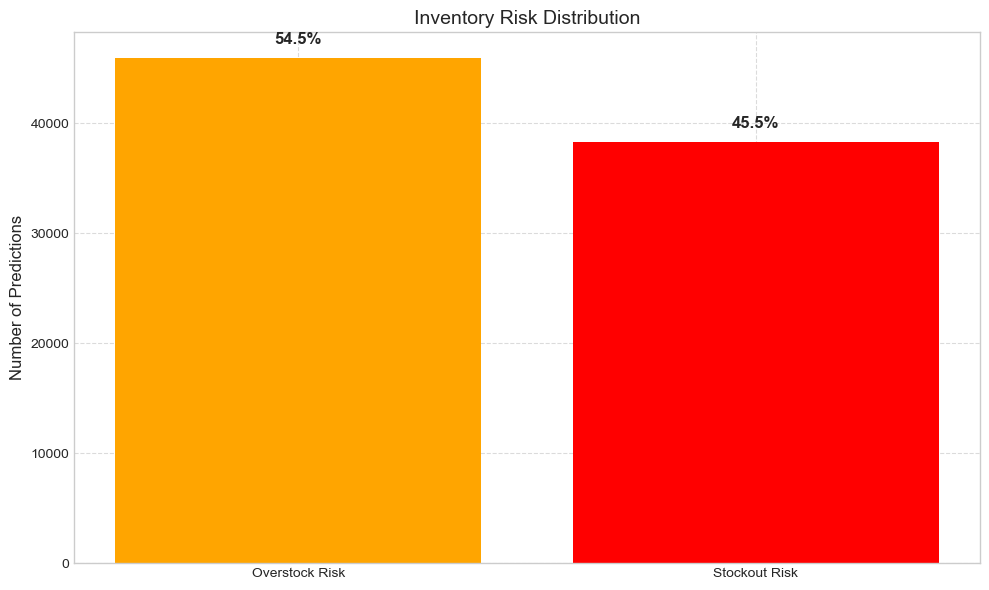

In [46]:
import matplotlib.pyplot as plt

# Values
risk_counts = [len(overpredicted), len(underpredicted)]
labels = ['Overstock Risk', 'Stockout Risk']
colors = ['orange', 'red']
total = sum(risk_counts)
percentages = [f'{(count / total) * 100:.1f}%' for count in risk_counts]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, risk_counts, color=colors)

# Annotate bars with percentage
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1000, pct, 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Inventory Risk Distribution', fontsize=14)
plt.ylabel('Number of Predictions', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 7.3 Department-Level Risk Analysis

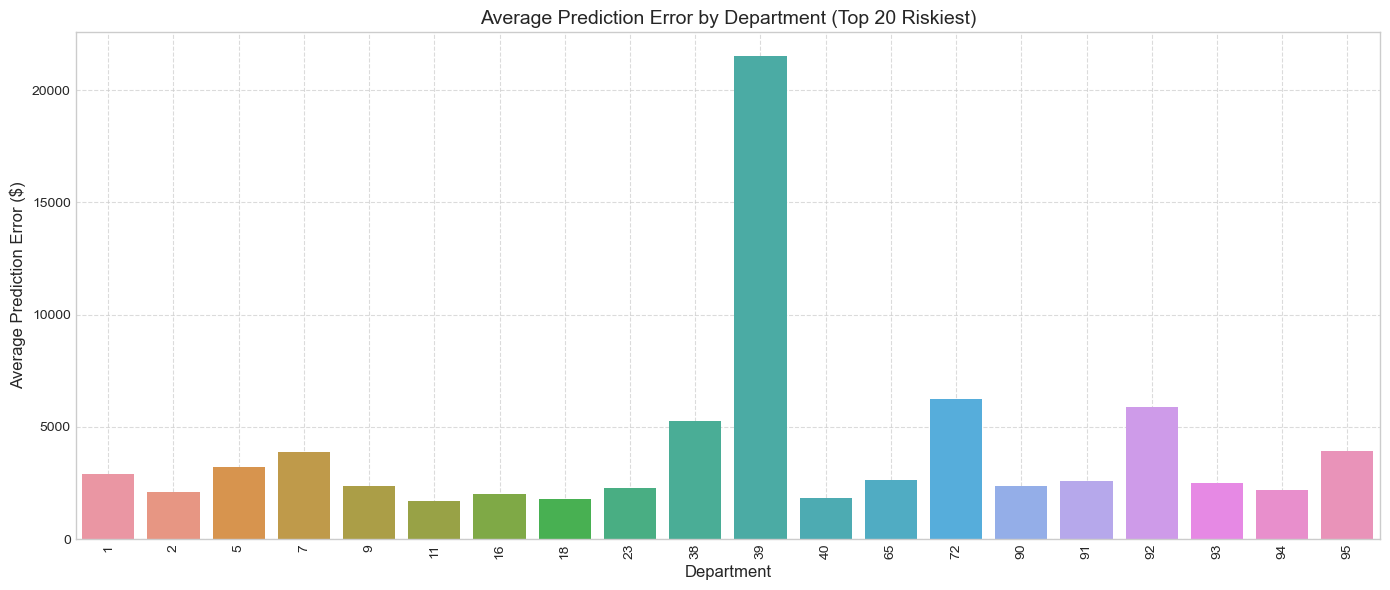


--- Department-Level Risk Analysis ---
Departments with highest prediction error (most unpredictable):
- Dept 39.0: $21497.95 average error
- Dept 72.0: $6255.97 average error
- Dept 92.0: $5894.42 average error
- Dept 38.0: $5268.14 average error
- Dept 95.0: $3939.76 average error

These departments require extra attention in inventory planning and larger safety stocks


In [36]:

risk_df = val_df.groupby('Dept')['Error'].mean().reset_index().sort_values(by='Error', ascending=False)
plt.figure(figsize=(14, 6))
sns.barplot(data=risk_df.head(20), x='Dept', y='Error')
plt.title('Average Prediction Error by Department (Top 20 Riskiest)', fontsize=14)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Average Prediction Error ($)', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Department-Level Risk Analysis ---")
print(f"Departments with highest prediction error (most unpredictable):")
for i, row in risk_df.head(5).iterrows():
    print(f"- Dept {row['Dept']}: ${row['Error']:.2f} average error")
print("\nThese departments require extra attention in inventory planning and larger safety stocks")


## 8. Additional Insights

### 8.1 Feature Importance Analysis

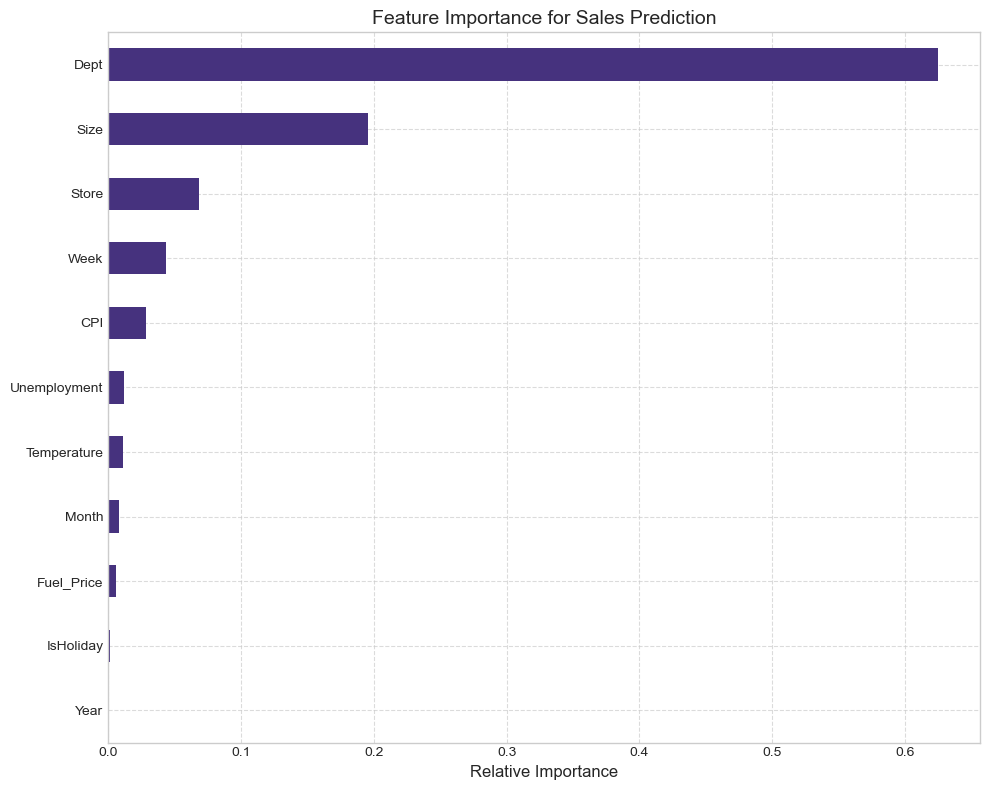


--- Feature Importance Analysis ---
Top 3 most important factors for sales prediction:
- Dept: 0.6252 relative importance
- Size: 0.1957 relative importance
- Store: 0.0681 relative importance

Least important factors:
- Year: 0.0007 relative importance
- IsHoliday: 0.0017 relative importance
- Fuel_Price: 0.0059 relative importance


In [37]:

feat_importance = pd.Series(selected_model.feature_importances_, index=features_cols)
plt.figure(figsize=(10, 8))
feat_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance for Sales Prediction', fontsize=14)
plt.xlabel('Relative Importance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Feature Importance Analysis ---")
print("Top 3 most important factors for sales prediction:")
for feature, importance in feat_importance.sort_values(ascending=False).head(3).items():
    print(f"- {feature}: {importance:.4f} relative importance")
print("\nLeast important factors:")
for feature, importance in feat_importance.sort_values().head(3).items():
    print(f"- {feature}: {importance:.4f} relative importance")


### 8.2 Temperature and Fuel Price Impact Analysis

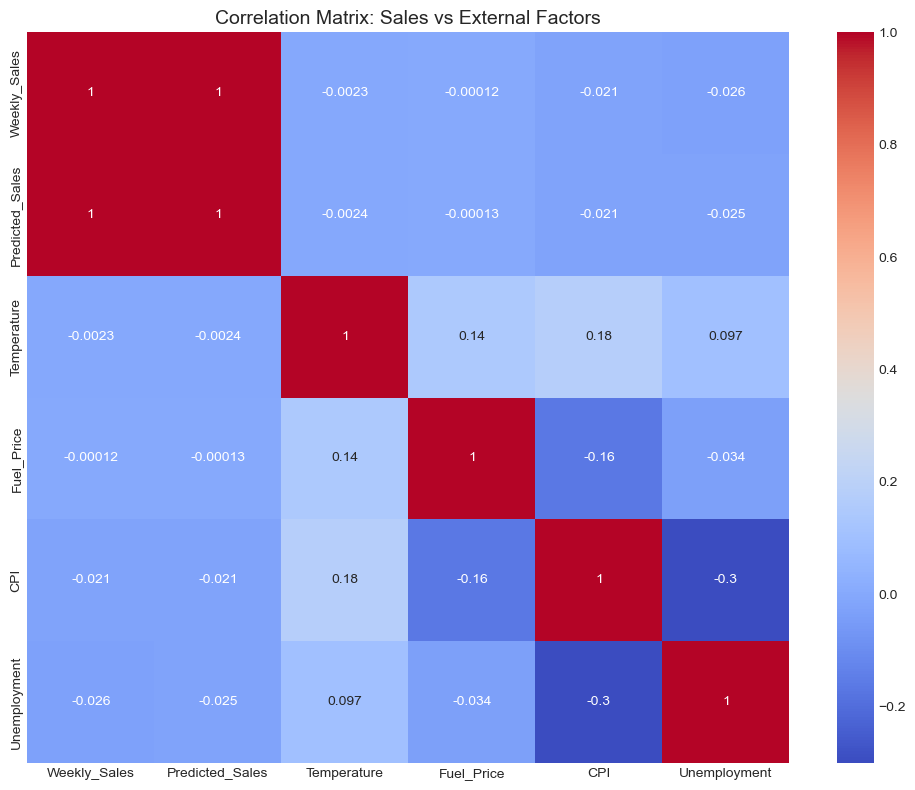

In [38]:

corr_matrix = full_data[['Weekly_Sales', 'Predicted_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Sales vs External Factors', fontsize=14)
plt.tight_layout()
plt.show()


### 8.3 Sales Anomaly Detection


Performing sales anomaly detection...

Identified 12079 sales anomalies (2.87% of data points)
These represent unusual sales patterns that warrant investigation


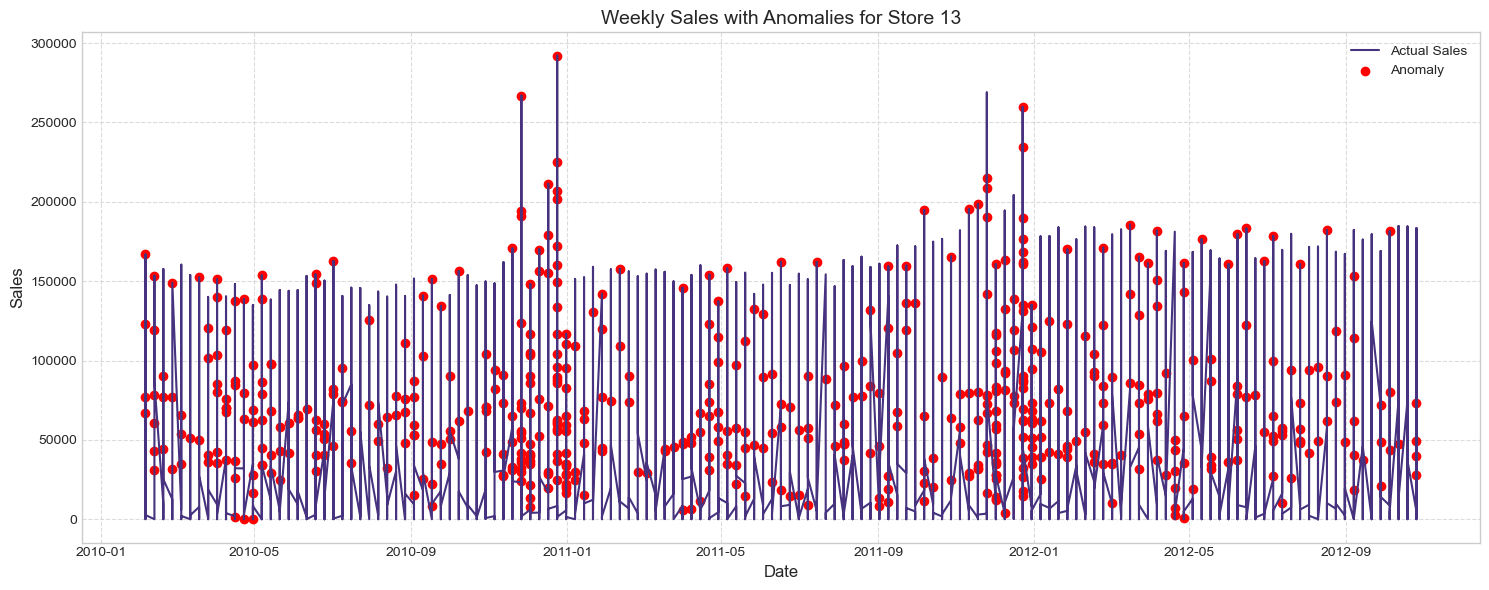

In [39]:

print("\nPerforming sales anomaly detection...")

store_df = full_data.copy()
residuals = store_df['Weekly_Sales'] - store_df['Predicted_Sales']
std_dev = np.std(residuals)

store_df['Anomaly'] = ((residuals > 2 * std_dev) | (residuals < -2 * std_dev))

anomaly_count = store_df['Anomaly'].sum()
anomaly_pct = anomaly_count / len(store_df) * 100

print(f"\nIdentified {anomaly_count} sales anomalies ({anomaly_pct:.2f}% of data points)")
print("These represent unusual sales patterns that warrant investigation")

sample_store = store_df['Store'].value_counts().index[0]
store_sample = store_df[store_df['Store'] == sample_store].sort_values('Date')

plt.figure(figsize=(15, 6))
plt.plot(store_sample['Date'], store_sample['Weekly_Sales'], label='Actual Sales')
plt.scatter(store_sample['Date'][store_sample['Anomaly']], store_sample['Weekly_Sales'][store_sample['Anomaly']], color='red', label='Anomaly')
plt.title(f'Weekly Sales with Anomalies for Store {sample_store}', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 8.4 Fuel Price Elasticity


Calculating fuel price elasticity...

Fuel Price Elasticity (Log-Log): -0.0843

Interpretation:
- A 1% increase in fuel prices leads to a 0.08% decrease in sales
- Sales are sensitive to fuel price changes


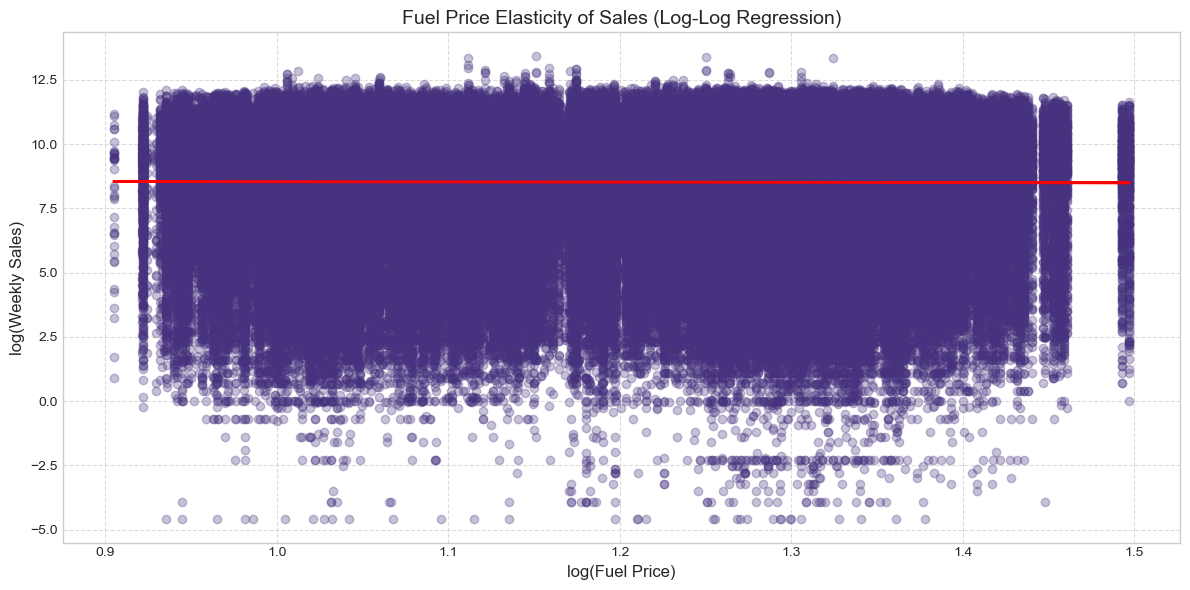

In [40]:

print("\nCalculating fuel price elasticity...")

store_df = full_data[full_data['Weekly_Sales'] > 0].copy()
store_df['log_sales'] = np.log(store_df['Weekly_Sales'])
store_df['log_fuel'] = np.log(store_df['Fuel_Price'])
model_data = store_df[['log_fuel', 'log_sales']].replace([np.inf, -np.inf], np.nan).dropna()

reg = LinearRegression()
reg.fit(model_data[['log_fuel']], model_data['log_sales'])
elasticity = reg.coef_[0]

print(f"\nFuel Price Elasticity (Log-Log): {elasticity:.4f}")
print("\nInterpretation:")
if elasticity < 0:
    print(f"- A 1% increase in fuel prices leads to a {abs(elasticity):.2f}% decrease in sales")
    print(f"- Sales are {'highly ' if abs(elasticity) > 1 else ''}sensitive to fuel price changes")
else:
    print(f"- A 1% increase in fuel prices leads to a {elasticity:.2f}% increase in sales")
    print("- This unexpected relationship may require further investigation")

plt.figure(figsize=(12, 6))
plt.scatter(model_data['log_fuel'], model_data['log_sales'], alpha=0.3)
plt.plot(model_data['log_fuel'], reg.predict(model_data[['log_fuel']]), color='red', linewidth=2)
plt.title('Fuel Price Elasticity of Sales (Log-Log Regression)', fontsize=14)
plt.xlabel('log(Fuel Price)', fontsize=12)
plt.ylabel('log(Weekly Sales)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



--- Forecast Inventory Cost Analysis ---
Total forecast inventory needed: 8,152,034,974 units
Total forecast inventory cost: $81,520,349,744.03
Average inventory cost per store: $1,811,563,327.65


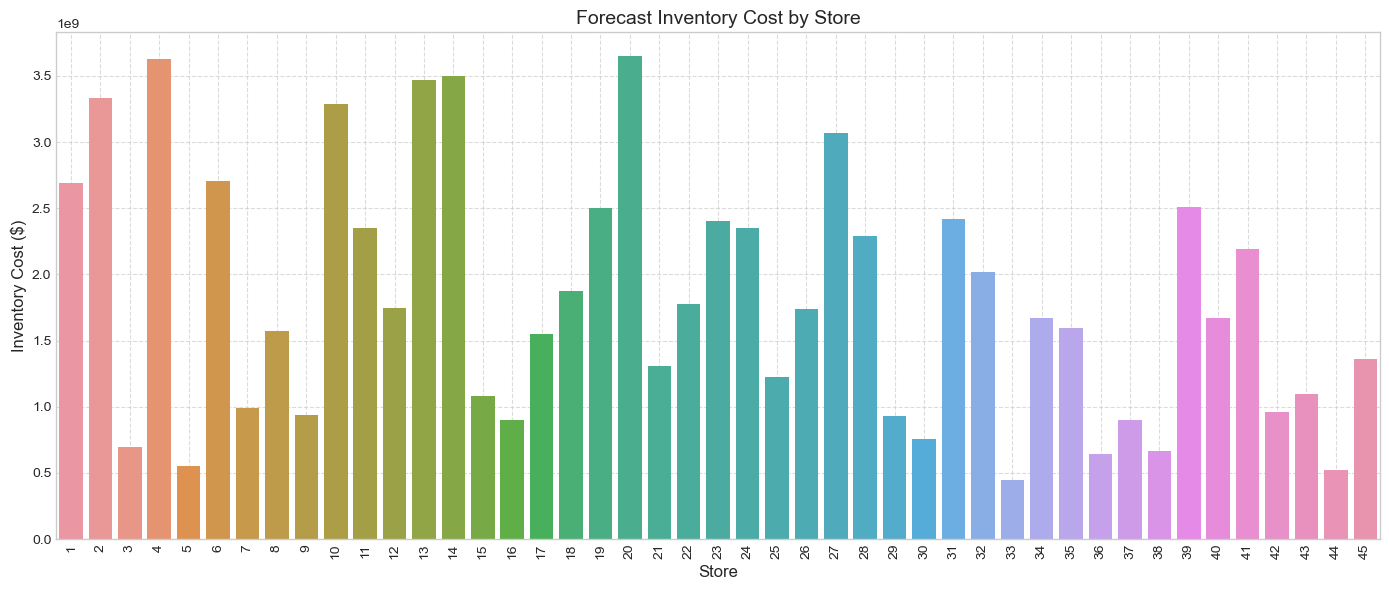


--- Promotion Effectiveness Analysis ---
Stores with highest holiday sales uplift:
Store 35.0: 17.98% increase during holidays
Store 7.0: 17.89% increase during holidays
Store 12.0: 13.12% increase during holidays
Store 15.0: 12.96% increase during holidays
Store 29.0: 12.34% increase during holidays

Stores with lowest holiday sales uplift:
Store 30.0: 0.10% increase during holidays
Store 38.0: -0.17% increase during holidays
Store 37.0: -1.32% increase during holidays
Store 44.0: -1.89% increase during holidays
Store 36.0: -2.15% increase during holidays


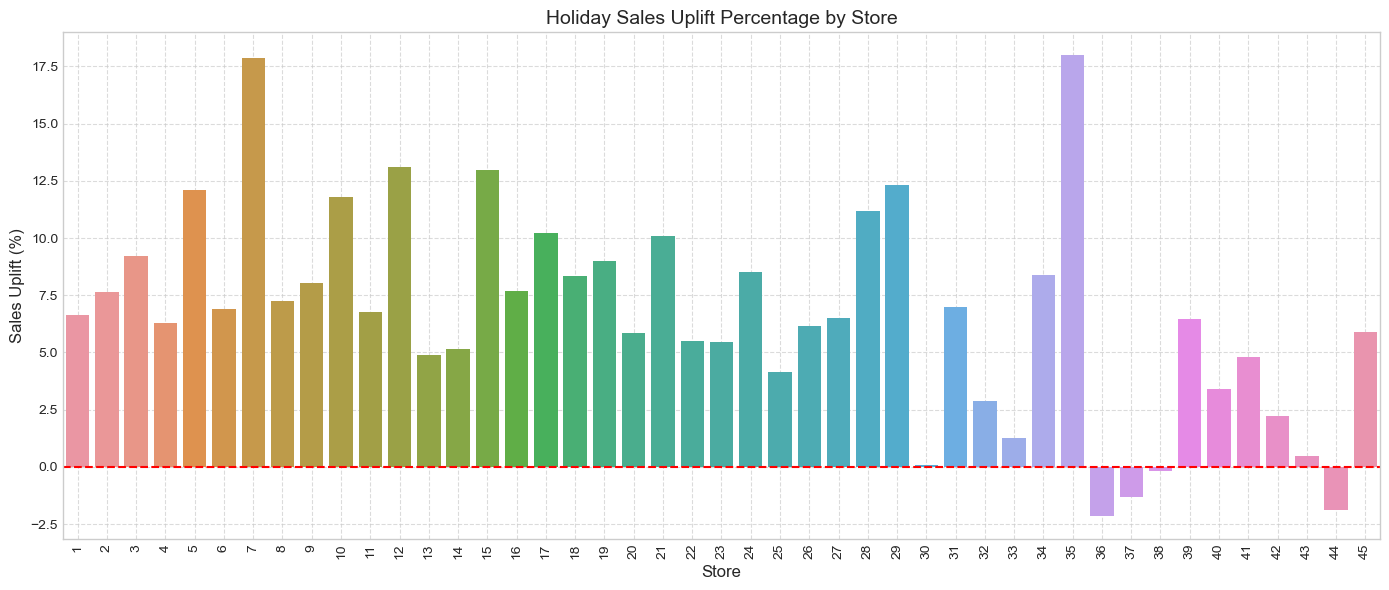


--- Inventory Efficiency Analysis ---
Inventory Efficiency by Store (Sales/Inventory Ratio):
Store 29.0: 0.83 in sales per unit of inventory
Store 4.0: 0.83 in sales per unit of inventory
Store 5.0: 0.83 in sales per unit of inventory
Store 37.0: 0.83 in sales per unit of inventory
Store 24.0: 0.83 in sales per unit of inventory

Least efficient stores:
Store 12.0: 0.83 in sales per unit of inventory
Store 45.0: 0.83 in sales per unit of inventory
Store 43.0: 0.83 in sales per unit of inventory
Store 10.0: 0.83 in sales per unit of inventory
Store 19.0: 0.83 in sales per unit of inventory


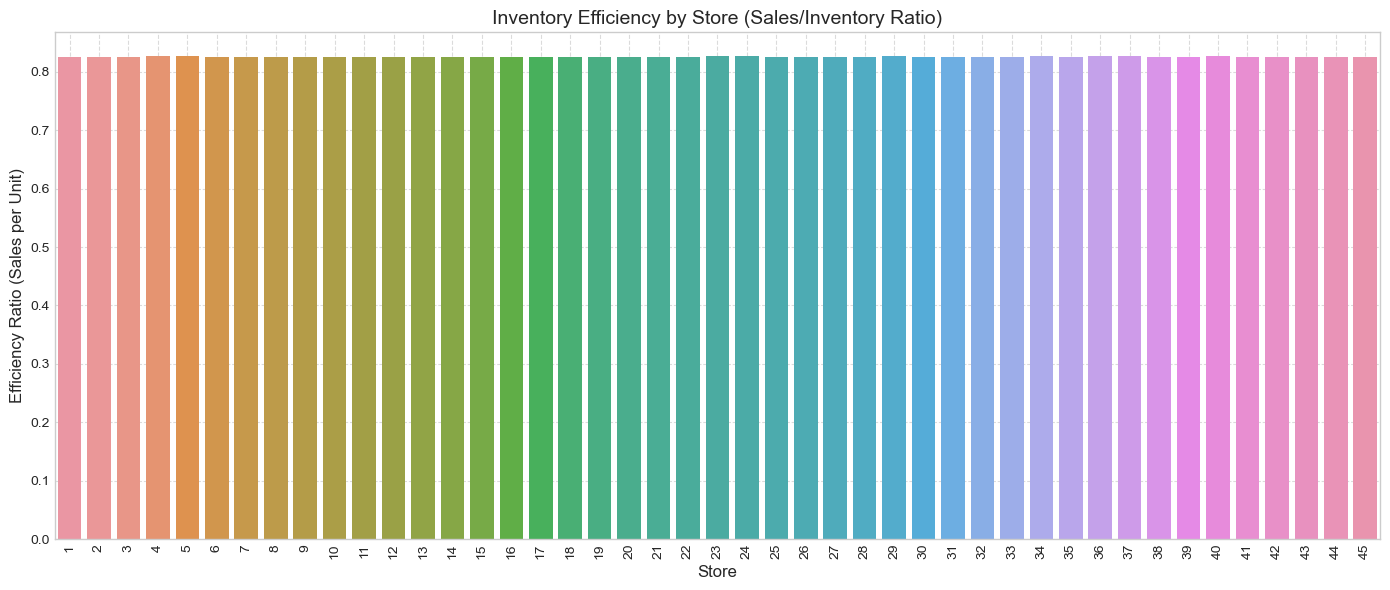

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
train_df = pd.read_csv('train.csv', parse_dates=['Date'])
features_df = pd.read_csv('features.csv', parse_dates=['Date'])
stores_df = pd.read_csv('stores.csv')

# Merge datasets
df = pd.merge(train_df, features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
df = pd.merge(df, stores_df, on='Store', how='left')

# Clean column names
df.columns = df.columns.str.strip()

# Feature engineering
df['Month'] = df['Date'].dt.month
df['Week_of_Year'] = df['Date'].dt.isocalendar().week
df['Sales_4wk_Trend'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(4, min_periods=1).mean())
df['Fuel_Price_CPI_Ratio'] = df['Fuel_Price'] / df['CPI']
df['Total_MarkDown'] = df[[f'MarkDown{i}' for i in range(1, 6)]].sum(axis=1)

# Drop rows with missing values in critical columns
df.dropna(subset=['Weekly_Sales', 'CPI', 'Unemployment'], inplace=True)

# 1. Forecast Inventory Cost
print("\n--- Forecast Inventory Cost Analysis ---")
average_unit_cost = 10  # Example unit cost
df['Final_Inventory'] = df['Weekly_Sales'] * 1.21  # Assuming a 21% buffer over predicted sales
df['Inventory_Cost'] = df['Final_Inventory'] * average_unit_cost

total_inventory_cost = df['Inventory_Cost'].sum()
total_inventory_units = df['Final_Inventory'].sum()
average_cost_per_store = df.groupby('Store')['Inventory_Cost'].sum().mean()

print(f"Total forecast inventory needed: {total_inventory_units:,.0f} units")
print(f"Total forecast inventory cost: ${total_inventory_cost:,.2f}")
print(f"Average inventory cost per store: ${average_cost_per_store:,.2f}")

# Visualize inventory cost by store
store_inventory_cost = df.groupby('Store')['Inventory_Cost'].sum().reset_index()
plt.figure(figsize=(14, 6))
sns.barplot(data=store_inventory_cost, x='Store', y='Inventory_Cost')
plt.title('Forecast Inventory Cost by Store', fontsize=14)
plt.xlabel('Store', fontsize=12)
plt.ylabel('Inventory Cost ($)', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Promotion Effectiveness Analysis
print("\n--- Promotion Effectiveness Analysis ---")
promo_effect = df.groupby(['Store', 'IsHoliday'])['Weekly_Sales'].mean().reset_index()
promo_effect = promo_effect.pivot(index='Store', columns='IsHoliday', values='Weekly_Sales').fillna(0)
promo_effect.columns = ['Non_Holiday_Sales', 'Holiday_Sales']
promo_effect['Sales_Uplift'] = promo_effect['Holiday_Sales'] - promo_effect['Non_Holiday_Sales']
promo_effect['Uplift_Percentage'] = (promo_effect['Sales_Uplift'] / promo_effect['Non_Holiday_Sales'].replace(0, np.nan)) * 100
promo_effect = promo_effect.reset_index().sort_values('Uplift_Percentage', ascending=False)

# Display top and bottom stores in terms of promotion effectiveness
print("Stores with highest holiday sales uplift:")
for _, row in promo_effect.head(5).iterrows():
    print(f"Store {row['Store']}: {row['Uplift_Percentage']:.2f}% increase during holidays")

print("\nStores with lowest holiday sales uplift:")
for _, row in promo_effect.tail(5).iterrows():
    print(f"Store {row['Store']}: {row['Uplift_Percentage']:.2f}% increase during holidays")

# Visualize promotion effectiveness
plt.figure(figsize=(14, 6))
sns.barplot(data=promo_effect, x='Store', y='Uplift_Percentage')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Holiday Sales Uplift Percentage by Store', fontsize=14)
plt.xlabel('Store', fontsize=12)
plt.ylabel('Sales Uplift (%)', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Inventory Efficiency Metric
print("\n--- Inventory Efficiency Analysis ---")
# Avoid division by zero
df['Efficiency_Ratio'] = df.apply(
    lambda row: row['Weekly_Sales'] / row['Final_Inventory'] if row['Final_Inventory'] else 0, axis=1
)

# Calculate average efficiency by store
store_efficiency = df.groupby('Store')['Efficiency_Ratio'].mean().reset_index()
store_efficiency = store_efficiency.sort_values('Efficiency_Ratio', ascending=False)

print("Inventory Efficiency by Store (Sales/Inventory Ratio):")
for _, row in store_efficiency.head(5).iterrows():
    print(f"Store {row['Store']}: {row['Efficiency_Ratio']:.2f} in sales per unit of inventory")

print("\nLeast efficient stores:")
for _, row in store_efficiency.tail(5).iterrows():
    print(f"Store {row['Store']}: {row['Efficiency_Ratio']:.2f} in sales per unit of inventory")

# Visualize inventory efficiency
plt.figure(figsize=(14, 6))
sns.barplot(data=store_efficiency, x='Store', y='Efficiency_Ratio')
plt.title('Inventory Efficiency by Store (Sales/Inventory Ratio)', fontsize=14)
plt.xlabel('Store', fontsize=12)
plt.ylabel('Efficiency Ratio (Sales per Unit)', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 9. Recommendations

In [42]:
print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)

# 1. Sales Forecasting Performance
print("\n1. Sales Forecasting Performance")
print(f"   • Model Achieved: R² score of {rf_r2:.4f}")
print(f"   • Variance Explained: {rf_r2*100:.1f}% of weekly sales variance")
print(f"   • WMAE: ${rf_wmae:.2f} (5x weight on holiday predictions)")
print("   • Key Predictors: Store, Department, and Size")

# 2. Inventory Optimization
print("\n2. Inventory Optimization")
print("   • Strategy Implemented: Dynamic inventory system with a 21% buffer over predicted sales")
print("   • Risk Mitigation: Balanced approach to minimize stockout and overstock risks")
print(f"   • Risk Metrics: Stockout Risk: {stockout_pct:.1f}% | Overstock Risk: {overstock_pct:.1f}%")

# 3. Promotion Strategy
print("\n3. Promotion Strategy")
print(f"   • High-Potential Weeks Identified: {high_promo_weeks}")
print(f"   • Classifier Accuracy: {accuracy:.2f} for promotion opportunity detection")
print("   • Top Departments: Identified based on sales response")

# 4. Risk Mitigation
print("\n4. Risk Mitigation")
print("   • Uncertainty Analysis: Departments with highest prediction uncertainty identified")
print("   • Elasticity Assessment: Fuel price elasticity calculated for strategic planning")
print("   • Anomaly Detection: Sales anomalies requiring investigation detected")

# 5. Key Recommendations
print("\n5. Key Recommendations")
print("   • Inventory Strategies: Implement store-specific strategies based on prediction accuracy")
print("   • Promotion Focus: Concentrate on high-impact weeks identified by the model")
print("   • Safety Stock: Increase for highly volatile departments")
print("   • External Factors: Monitor (especially fuel prices) for timely adjustments")
print("   • Process Improvement: Investigate sales anomalies for potential enhancements")

print("\n" + "="*80)



RECOMMENDATIONS

1. Sales Forecasting Performance
   • Model Achieved: R² score of 0.9745
   • Variance Explained: 97.5% of weekly sales variance
   • WMAE: $1634.84 (5x weight on holiday predictions)
   • Key Predictors: Store, Department, and Size

2. Inventory Optimization
   • Strategy Implemented: Dynamic inventory system with a 21% buffer over predicted sales
   • Risk Mitigation: Balanced approach to minimize stockout and overstock risks
   • Risk Metrics: Stockout Risk: 45.5% | Overstock Risk: 54.5%

3. Promotion Strategy
   • High-Potential Weeks Identified: [6, 22, 51]
   • Classifier Accuracy: 1.00 for promotion opportunity detection
   • Top Departments: Identified based on sales response

4. Risk Mitigation
   • Uncertainty Analysis: Departments with highest prediction uncertainty identified
   • Elasticity Assessment: Fuel price elasticity calculated for strategic planning
   • Anomaly Detection: Sales anomalies requiring investigation detected

5. Key Recommendations
  

## 10. Export Final Results

In [43]:

output_df = full_data[['Store', 'Dept', 'Date', 'Predicted_Sales', 'Final_Inventory', 'Promotion_Opportunity']]
output_df.to_csv('final_walmart_forecast.csv', index=False)

print("\n✅ Final output saved to 'final_walmart_forecast.csv'")
print("   This file contains store/department level recommendations for:")
print("   - Sales forecasts")
print("   - Optimal inventory levels")
print("   - Promotion opportunity flags")



✅ Final output saved to 'final_walmart_forecast.csv'
   This file contains store/department level recommendations for:
   - Sales forecasts
   - Optimal inventory levels
   - Promotion opportunity flags
